# 1) Preprocessing  

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle


# ---------- Functions ----------

# Print the number of FoG and no-event labels in the datasets
def print_label_distribution(y_data, dataset_name):
    num_fog = np.sum(y_data)
    num_no_fog = len(y_data) - num_fog
    print(f"{dataset_name}:")
    print(f"  FoG events: {num_fog}")
    print(f"  No events: {num_no_fog}")
    print()

# Function to normalize spikegrams
def normalize_spikegram(spikegram_dict, scaler, axes):
    normalized_spikegrams = []
    
    for axis in axes:
        normalized_axis = scaler.fit_transform(spikegram_dict[axis].reshape(-1, 1)).reshape(spikegram_dict[axis].shape)
        normalized_spikegrams.append(normalized_axis)
    
    # Stack along a new axis for multi-channel representation
    return np.stack(normalized_spikegrams, axis=-1)

# Function to generate labels
def generate_labels(fog_dict, events):
    labels = np.zeros(len(next(iter(fog_dict.values()))), dtype=int)
    for i, event in enumerate(events, start=1):
        labels[np.where(fog_dict[event] == 1)] = 1
    return labels

# Function to filter files based on the presence of target events
def filter_files(file_paths, events):
    valid_files = []
    for file_path in file_paths:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            fog_dict = data['spikegram_fog_dict']

        # Check if any target event exists in the file
        has_target_event = any(np.any(fog_dict[event] == 1) for event in events)
        if has_target_event:
            valid_files.append(file_path)

    return valid_files

# Function to create windows from sequences
def create_windows(data, labels, window_size, step_size):
    X_windows, y_windows = [], []
    for sequence, label_seq in zip(data, labels):
        for start in range(0, len(label_seq) - window_size + 1, step_size):
            end = start + window_size
            X_windows.append(sequence[:, start:end])
            
            # Assign a single label to the window based on majority voting
            y_window = label_seq[start:end]
            majority_label = 1 if np.sum(y_window) > (window_size / 2) else 0
            y_windows.append(majority_label)  # Binary classification
    
    return X_windows, y_windows

# Function to load data from a .pkl file
def load_data(file_paths, axes, events, window_size, step_size):
    X, y = [], []
    scaler = MinMaxScaler()

    for file_path in file_paths:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        spikegram_dict = data['spikegram_dict']
        fog_dict = data['spikegram_fog_dict']

        spikegram = normalize_spikegram(spikegram_dict, scaler, axes)
        fog_labels = generate_labels(fog_dict, events)

        X.append(spikegram)
        y.append(fog_labels)
    
    # Windowing
    X, y = create_windows(X, y, window_size, step_size)
        

    X = np.array(X)
    y = np.array(y)  # Shape: (#files, max_time_bins)

    return X, y

# ---------- Body ----------

# Load all file paths
# data_directory = r'D:\University\tdscfog_spikegram_offline_data' # Partial files, using only the low sizes
data_directory = r'D:\University\tdscfog_spikegram_offline_data_full' # Full files, including the large size files

file_paths = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith('.pkl')]

# Filter files based on the presence of target events
events = ['Turn', 'Walking']  # Target events
axes = ['AccV', 'AccML', 'AccAP']  # Using all axes
filtered_files = filter_files(file_paths, events)
print(f"Number of valid files after filtering: {len(filtered_files)}")

# Fixed test files while shuffling train and validation files for reproducibility (currently not shuffling)
temp_files, test_files = train_test_split(filtered_files, test_size=0.15, random_state=42)
train_files, val_files = train_test_split(temp_files, test_size=0.15, random_state=42)

# train_files, val_files = train_test_split(temp_files, test_size=0.15, random_state=np.random.seed())

print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")
print()

'''
# Apply windowing
window_size = 500  # 5 seconds
step_size = window_size // 2  # 50% overlap
'''

# Apply windowing
window_size = 300  # 2 seconds
step_size = window_size // 2  # 50% overlap


# Load data for the specific axis and events
X_train, y_train = load_data(train_files, axes, events, window_size, step_size)
X_val, y_val = load_data(val_files, axes, events, window_size, step_size)
X_test, y_test = load_data(test_files, axes, events, window_size, step_size)

# Print shapes of the data
print("X shape: (Samples, frequencies, time bins, channels)")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print()

'''
# Reshape data to match Network input requirements
print(X_train.shape)
X_train = np.transpose(X_train, (0, 2, 1))  # Shape: (windows, time_bins, features)
X_val = np.transpose(X_val, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

# Print shapes for debugging
print(f"X_train shape (after windowing): {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape (after windowing): {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape (after windowing): {X_test.shape}, y_test shape: {y_test.shape}")
print()
'''

# Print the number of FoG events in each label set
print_label_distribution(y_train, "Training Labels")
print_label_distribution(y_val, "Validation Labels")
print_label_distribution(y_test, "Test Labels")

del axes, data_directory, file_paths, filtered_files, temp_files, test_files, train_files, val_files, events

Number of valid files after filtering: 404
Train files: 291
Validation files: 52
Test files: 61

X shape: (Samples, frequencies, time bins, channels)
X_train shape: (16925, 8, 300, 3), y_train shape: (16925,)
X_val shape: (2994, 8, 300, 3), y_val shape: (2994,)
X_test shape: (3305, 8, 300, 3), y_test shape: (3305,)

Training Labels:
  FoG events: 7199
  No events: 9726

Validation Labels:
  FoG events: 1269
  No events: 1725

Test Labels:
  FoG events: 1315
  No events: 1990



# 2) Classic ML

## Data Preprocessing for Classic ML

In [36]:
import os

def flatten_data(X, y):
    return X.reshape(X.shape[0], -1), y

X_train_classic, y_train_classic = flatten_data(X_train, y_train)
X_val_classic, y_val_classic = flatten_data(X_val, y_val)
X_test_classic, y_test_classic = flatten_data(X_test, y_test)

# Print shapes of the data for classic ML
print("X shape for classic ML: (Samples, features)")
print(f"X_train_classic shape: {X_train_classic.shape}, y_train_classic shape: {y_train_classic.shape}")
print(f"X_val_classic shape: {X_val_classic.shape}, y_val_classic shape: {y_val_classic.shape}")
print(f"X_test_classic shape: {X_test_classic.shape}, y_test_classic shape: {y_test_classic.shape}")
print()

results_dir = os.path.join(f'Window-{window_size//100} seconds, Overlap-{(step_size/window_size)*100}%')
os.makedirs(results_dir, exist_ok=True)  # Create the directory if it doesn't exist

X shape for classic ML: (Samples, features)
X_train_classic shape: (25668, 4800), y_train_classic shape: (25668,)
X_val_classic shape: (4546, 4800), y_val_classic shape: (4546,)
X_test_classic shape: (5017, 4800), y_test_classic shape: (5017,)



## Classic ML Models

In [37]:
import os
import joblib  # For saving/loading models
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False)
}

# Results storage
results = []

# Define model save path
model_save_dir = os.path.join(results_dir, "classic ML models")
os.makedirs(model_save_dir, exist_ok=True)

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_classic, y_train_classic)
    y_pred = model.predict(X_test_classic)
    y_prob = model.predict_proba(X_test_classic)[:, 1] if hasattr(model, "predict_proba") else None

    # Save the trained model
    model_path = os.path.join(model_save_dir, f"{name.replace(' ', '_')}.joblib")
    joblib.dump(model, model_path)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test_classic, y_pred).ravel()

    # Metrics Calculation
    accuracy = accuracy_score(y_test_classic, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    auc = roc_auc_score(y_test_classic, y_prob) if y_prob is not None else None

    # Save results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "AUC": auc,
        "Model Path": model_path
    })

# Convert results to DataFrame and save to CSV
output_dir = os.path.join(results_dir, "classic ML results")
output_file = os.path.join(output_dir, "models_result_comparison.csv")
os.makedirs(output_dir, exist_ok=True)  # Create directory if not exist

results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)

# Print results
print(results_df)
print(f"Results saved to: {output_file}")
print(f"Models saved to: {model_save_dir}")

C:\Users\etaiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [05:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  Sensitivity  Specificity       AUC  \
0  Logistic Regression  0.744867     0.643974     0.810811  0.818649   
1        Decision Tree  0.674905     0.566818     0.745550  0.656184   
2        Random Forest  0.775563     0.586485     0.899143  0.855834   
3                  KNN  0.716962     0.767524     0.683916  0.784692   
4          Naive Bayes  0.710584     0.808371     0.646671  0.748789   
5                  SVM  0.735499     0.673222     0.776203  0.810949   
6              XGBoost  0.777955     0.635401     0.871127  0.863433   

                                          Model Path  
0  Window-2 seconds, Overlap-50.0%\classic ML mod...  
1  Window-2 seconds, Overlap-50.0%\classic ML mod...  
2  Window-2 seconds, Overlap-50.0%\classic ML mod...  
3  Window-2 seconds, Overlap-50.0%\classic ML mod...  
4  Window-2 seconds, Overlap-50.0%\classic ML mod...  
5  Window-2 seconds, Overlap-50.0%\classic ML mod...  
6  Window-2 seconds, Overlap-50.0%\cla

In [38]:
import joblib

# Load a specific model (e.g., Random Forest)
model_path = os.path.join(model_save_dir, "Random_Forest.joblib")
loaded_model = joblib.load(model_path)

# Predict on new data (X_new should have the same features as training data)
y_new_pred = loaded_model.predict(X_test_classic)
y_new_prob = loaded_model.predict_proba(X_test_classic)[:, 1] if hasattr(loaded_model, "predict_proba") else None

print(f"Predictions: {y_new_pred}")
print(f"Probabilities: {y_new_prob}")


Predictions: [0 0 0 ... 0 0 0]
Probabilities: [0.   0.13 0.12 ... 0.08 0.09 0.16]


# 3) CNN Algorithm

## Data Preprocessing for CNN Models

In [4]:
import os

def conv1d_data(X, y):
    return X.reshape(X.shape[0], X.shape[2], -1), y

def conv2d_data(X, y):
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3]), y

X_train_conv1d, y_train_conv1d = conv1d_data(X_train, y_train)
X_val_conv1d, y_val_conv1d = conv1d_data(X_val, y_val)
X_test_conv1d, y_test_conv1d = conv1d_data(X_test, y_test)

X_train_conv2d, y_train_conv2d = conv2d_data(X_train, y_train)
X_val_conv2d, y_val_conv2d = conv2d_data(X_val, y_val)
X_test_conv2d, y_test_conv2d = conv2d_data(X_test, y_test)

# Print shapes of the data for conv1d model
print("X shape for Conv1D: (Samples, time bins, features)")
print(f"X_train_conv1d shape: {X_train_conv1d.shape}, y_train_conv1d shape: {y_train_conv1d.shape}")
print(f"X_val_conv1d shape: {X_val_conv1d.shape}, y_val_conv1d shape: {y_val_conv1d.shape}")
print(f"X_test_conv1d shape: {X_test_conv1d.shape}, y_test_conv1d shape: {y_test_conv1d.shape}")
print()

# Print shapes of the data for conv2d model
print("X shape for Conv2D: (Samples, frequencies(height), time bins(width), axes(channels))")
print(f"X_train_conv2d shape: {X_train_conv2d.shape}, y_train_conv2d shape: {y_train_conv2d.shape}")
print(f"X_val_conv2d shape: {X_val_conv2d.shape}, y_valshape: {y_val_conv2d.shape}")
print(f"X_test_conv2d shape: {X_test_conv2d.shape}, y_test shape: {y_test_conv2d.shape}")
print()

results_dir = os.path.join(f'Window-{window_size//100} seconds, Overlap-{(step_size/window_size)*100}%')
os.makedirs(results_dir, exist_ok=True)  # Create the directory if it doesn't exist

output_dir = os.path.join(results_dir, "CNN Models")

# Conv1D
conv1d_output_dir = os.path.join(output_dir, "Conv1D")
os.makedirs(conv1d_output_dir, exist_ok=True)
conv1d_tuning_output_dir = os.path.join(conv1d_output_dir, "Tuning")
os.makedirs(conv1d_tuning_output_dir, exist_ok=True)

# Conv2D
conv2d_output_dir = os.path.join(output_dir, "Conv2D")
os.makedirs(conv2d_output_dir, exist_ok=True)
conv2d_tuning_output_dir = os.path.join(conv2d_output_dir, "Tuning")
os.makedirs(conv2d_tuning_output_dir, exist_ok=True)

X shape for Conv1D: (Samples, time bins, features)
X_train_conv1d shape: (16925, 300, 24), y_train_conv1d shape: (16925,)
X_val_conv1d shape: (2994, 300, 24), y_val_conv1d shape: (2994,)
X_test_conv1d shape: (3305, 300, 24), y_test_conv1d shape: (3305,)

X shape for Conv2D: (Samples, frequencies(height), time bins(width), axes(channels))
X_train_conv2d shape: (16925, 8, 300, 3), y_train_conv2d shape: (16925,)
X_val_conv2d shape: (2994, 8, 300, 3), y_valshape: (2994,)
X_test_conv2d shape: (3305, 8, 300, 3), y_test shape: (3305,)



## Conv1D

### Initial Model

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Determine input shape dynamically
time_bins = X_train_conv1d.shape[1]
num_features = X_train_conv1d.shape[2]

# Conv1D Model
conv1d_model = Sequential([
    Input(shape=(time_bins, num_features)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
conv1d_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_conv1d = conv1d_model.fit(X_train_conv1d, y_train_conv1d,
                                  validation_data=(X_val_conv1d, y_val_conv1d),
                                  epochs=20,
                                  batch_size=32,
                                  verbose=2)

# Save the model
conv1d_initial_output_dir = os.path.join(conv1d_output_dir, "Initial")
os.makedirs(conv1d_initial_output_dir, exist_ok=True)
conv1d_model.save(os.path.join(conv1d_initial_output_dir, "conv1d_initial_model.keras"))

Epoch 1/20
803/803 - 10s - 12ms/step - accuracy: 0.7816 - loss: 0.4654 - val_accuracy: 0.7532 - val_loss: 0.5186
Epoch 2/20
803/803 - 6s - 8ms/step - accuracy: 0.8028 - loss: 0.4199 - val_accuracy: 0.7651 - val_loss: 0.4902
Epoch 3/20
803/803 - 6s - 8ms/step - accuracy: 0.8083 - loss: 0.4035 - val_accuracy: 0.7668 - val_loss: 0.4736
Epoch 4/20
803/803 - 6s - 8ms/step - accuracy: 0.8158 - loss: 0.3866 - val_accuracy: 0.7774 - val_loss: 0.4803
Epoch 5/20
803/803 - 6s - 8ms/step - accuracy: 0.8237 - loss: 0.3737 - val_accuracy: 0.7697 - val_loss: 0.4773
Epoch 6/20
803/803 - 6s - 8ms/step - accuracy: 0.8288 - loss: 0.3620 - val_accuracy: 0.7785 - val_loss: 0.5074
Epoch 7/20
803/803 - 6s - 8ms/step - accuracy: 0.8340 - loss: 0.3500 - val_accuracy: 0.7800 - val_loss: 0.4574
Epoch 8/20
803/803 - 6s - 8ms/step - accuracy: 0.8432 - loss: 0.3364 - val_accuracy: 0.7692 - val_loss: 0.5140
Epoch 9/20
803/803 - 6s - 8ms/step - accuracy: 0.8495 - loss: 0.3270 - val_accuracy: 0.7761 - val_loss: 0.5025

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7762
Sensitivity: 0.6601
Specificity: 0.8520
AUC: 0.8732

Metrics Table:
        Metric     Value
0     Accuracy  0.776161
1  Sensitivity  0.660111
2  Specificity  0.852011
3          AUC  0.873156

Metrics saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv1D\Initial\metrics_results.csv


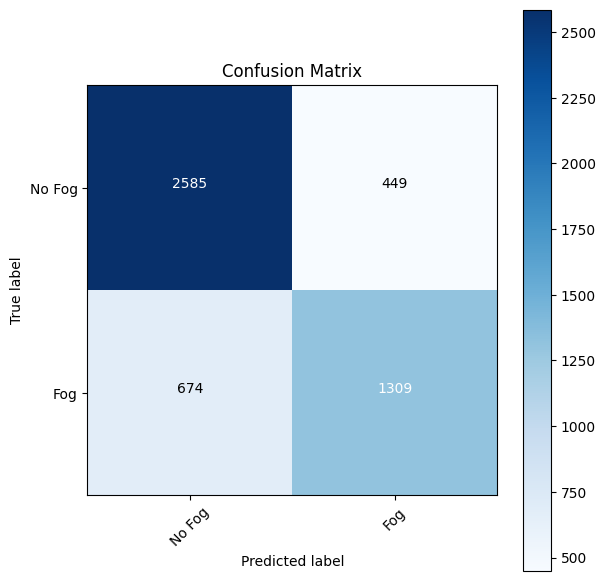

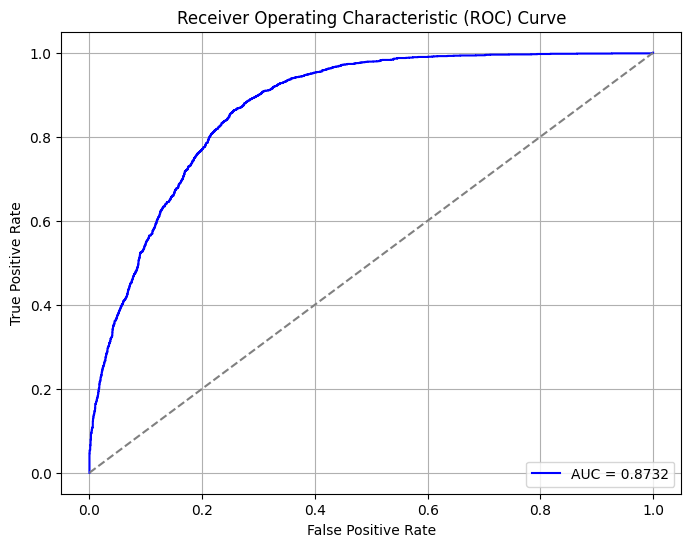

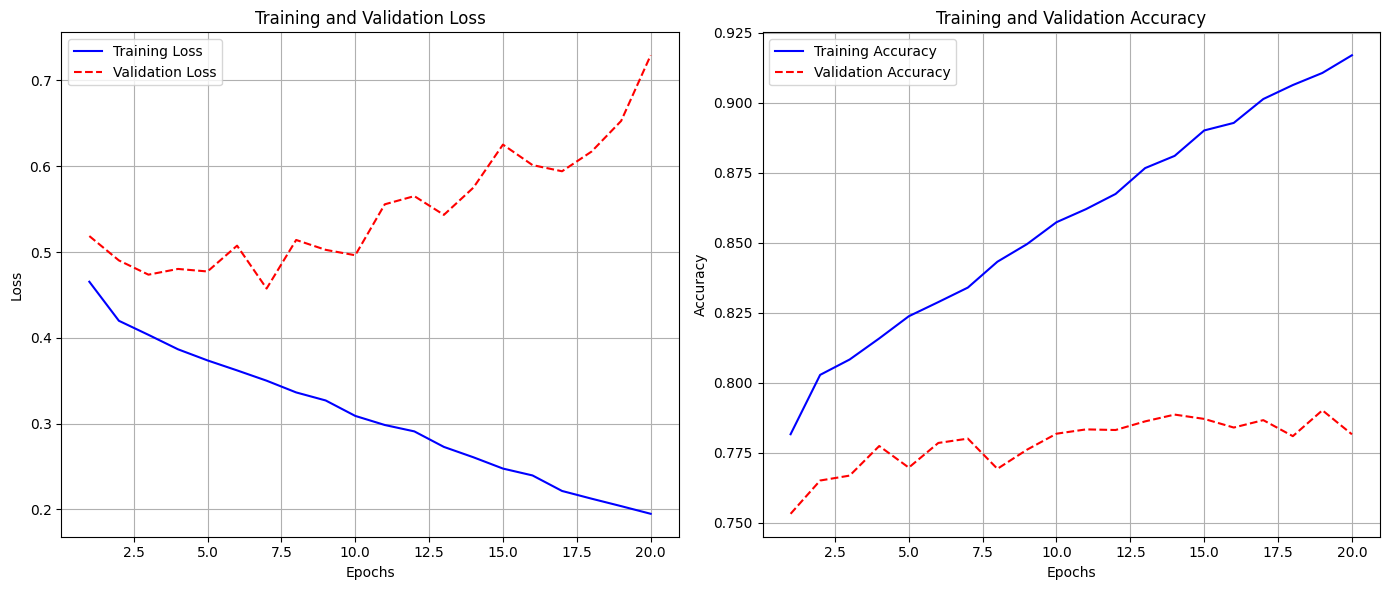

Training and validation metrics saved as subplots to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv1D\Initial\training_validation_graph.png


In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

# Predict on the test set
y_test_pred = (conv1d_model.predict(X_test_conv1d) > 0.5).astype("int32")  # Threshold at 0.5
y_test_prob = conv1d_model.predict(X_test_conv1d).flatten()  # Probabilities for AUC

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test_conv1d, y_test_pred).ravel()

# Metrics Calculation
accuracy = accuracy_score(y_test_conv1d, y_test_pred)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity = Recall
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
auc_score = roc_auc_score(y_test_conv1d, y_test_prob)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {auc_score:.4f}")

# Create a DataFrame to store the results
import pandas as pd

metrics = {
    "Metric": ["Accuracy", "Sensitivity", "Specificity", "AUC"],
    "Value": [accuracy, sensitivity, specificity, auc_score]
}

metrics_df = pd.DataFrame(metrics)

# Save the metrics table to the specified directory
metrics_output_file = os.path.join(conv1d_initial_output_dir, "metrics_results.csv")
metrics_df.to_csv(metrics_output_file, index=False)

print("\nMetrics Table:")
print(metrics_df)
print(f"\nMetrics saved to: {metrics_output_file}")

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf_matrix = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(6, 6))
plot_confusion_matrix(conf_matrix, classes=["No Fog", "Fog"], title="Confusion Matrix")
plt.savefig(os.path.join(conv1d_initial_output_dir, "confusion_matrix.png"))
plt.show()

# Plot ROC and AUC curve
fpr, tpr, thresholds = roc_curve(y_test_conv1d, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig(os.path.join(conv1d_initial_output_dir, "auc_curve.png"))
plt.show()

def plot_training_curves_with_subplots(history, output_dir):
    # Extract loss and accuracy from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Create a figure with subplots
    plt.figure(figsize=(14, 6))

    # Subplot for Loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Subplot for Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Adjust layout and save
    plt.tight_layout()
    combined_plot_path = os.path.join(output_dir, "training_validation_graph.png")
    plt.savefig(combined_plot_path)
    plt.show()

    print(f"Training and validation metrics saved as subplots to: {combined_plot_path}")

plot_training_curves_with_subplots(history_conv1d, conv1d_initial_output_dir)

### Hyper-Parameters Tuning

#### Parameter Tuning

In [42]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Define the model-building function
def build_conv1d_model(hp):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=(X_train_conv1d.shape[1], X_train_conv1d.shape[2])))

    # Convolutional Layers
    for i in range(hp.Int("num_conv_layers", 1, 3)):  # 2 to 3 Conv1D layers
        model.add(
            Conv1D(
                filters=hp.Int(f"filters_{i}", min_value=8, max_value=48, step=8),  # Filters: 8 to 48
                kernel_size=hp.Choice(f"kernel_size_{i}", [3]),  # Kernel sizes
                activation="relu"
            )
        )
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling1D(pool_size=2))    # Max pooling
        model.add(Dropout(rate=0.4))  # Dropout

    # Fully Connected Layers
    model.add(Flatten())
    for i in range(hp.Int("num_dense_layers", 1, 2)):  # 1 to 2 Dense layers
        model.add(
            Dense(
                units=hp.Int(f"dense_units_{i}", min_value=8, max_value=64, step=8),  # Dense units: 16 to 128
                activation="relu"
            )
        )
        model.add(Dropout(rate=hp.Float(f"dense_dropout_{i}", 0.2, 0.5, step=0.1)))  # Dense dropout

    # Output Layer
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", 1e-5, 1e-3, sampling="log")),  # Learning rate
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Recall(name="sensitivity"), tf.keras.metrics.AUC(name="auc")],
    )
    return model

'''
# Instantiate the Random Search tuner
tuner = kt.RandomSearch(
    build_conv1d_model,
    objective=kt.Objective("val_auc", direction="max"),  # Maximize AUC
    max_trials=100,  # Number of configurations to try
    executions_per_trial=1,  # Number of training runs per configuration
    directory=os.path.join(conv1d_output_dir, "tuning"),
    project_name="conv1d_random_search"
)
'''
'''
tuner = kt.Hyperband(
    build_conv1d_model,  # Model-building function
    objective=kt.Objective("val_auc", direction="max"),  # Maximize AUC
    max_epochs=30,  # Maximum number of epochs per configuration
    factor=2,  # Resource reduction factor
    directory=os.path.join(conv1d_output_dir, "tuning"),
    project_name="conv1d_hyperband"
)
'''

tuner = kt.BayesianOptimization(
    build_conv1d_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=50,
    directory=os.path.join(conv1d_output_dir, "tuning"),
    project_name="conv1d_bayesian_optimization"
)

# Define a callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Perform the search
tuner.search(
    X_train_conv1d, y_train_conv1d,
    validation_data=(X_val_conv1d, y_val_conv1d),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Save the best model
best_model.save(os.path.join(conv1d_tuning_output_dir, "best_conv1d_model.keras"))

Trial 50 Complete [00h 01m 26s]
val_auc: 0.8466017842292786

Best val_auc So Far: 0.8669209480285645
Total elapsed time: 01h 07m 17s

Best Hyperparameters:
num_conv_layers: 2
filters_0: 48
kernel_size_0: 3
num_dense_layers: 2
dense_units_0: 40
dense_dropout_0: 0.2
learning_rate: 0.001
filters_1: 32
kernel_size_1: 3
filters_2: 24
kernel_size_2: 3
dense_units_1: 32
dense_dropout_1: 0.2


C:\Users\etaiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Best Trials

In [43]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix

# Directory to save the top models
top_models_dir = os.path.join(conv1d_output_dir, "top_10_models")
os.makedirs(top_models_dir, exist_ok=True)

# Get the top 10 trials from the tuner
best_trials = tuner.oracle.get_best_trials(num_trials=10)
best_models = tuner.get_best_models(num_models=10)  # Retrieve trained models

data = []
for i, (trial, model) in enumerate(zip(best_trials, best_models)):
    # Extract hyperparameters
    num_conv_layers = trial.hyperparameters.get("num_conv_layers")
    num_dense_layers = trial.hyperparameters.get("num_dense_layers")
    filters = [trial.hyperparameters.get(f"filters_{j}") for j in range(num_conv_layers)]
    kernel_sizes = [trial.hyperparameters.get(f"kernel_size_{j}") for j in range(num_conv_layers)]
    dense_units = [trial.hyperparameters.get(f"dense_units_{j}") for j in range(num_dense_layers)]
    learning_rate = trial.hyperparameters.get("learning_rate")

    # Retrieve validation metrics directly from the tuner
    val_accuracy = round(trial.metrics.get_best_value("val_accuracy"), 4)
    val_sensitivity = round(trial.metrics.get_best_value("val_sensitivity"), 4)
    val_auc = round(trial.metrics.get_best_value("val_auc"), 4)

    # Save the best model
    model_path = os.path.join(top_models_dir, f"model_{i + 1}.keras")
    model.save(model_path)

    # Calculate specificity on the validation set
    y_val_pred = (model.predict(X_val_conv1d) > 0.5).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_val_conv1d, y_val_pred).ravel()
    val_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Save model data
    trial_data = {
        "Model Rank": i + 1,
        "Num Conv Layers": num_conv_layers,
        "Filters Per Layer": filters,
        "Kernel Sizes": kernel_sizes,
        "Num Dense Layers": num_dense_layers,
        "Dense Units": dense_units,
        "Learning Rate": learning_rate,
        "Validation Accuracy": val_accuracy,
        "Validation Sensitivity": val_sensitivity,
        "Validation Specificity": round(val_specificity, 4),
        "Validation AUC": val_auc,
        "Model Path": model_path,
    }
    data.append(trial_data)

# Convert the results to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_path = os.path.join(top_models_dir, "top_10_models.csv")
df.to_csv(csv_path, index=False)

# Print the saved paths
print(f"Top models saved to: {top_models_dir}")
print(f"Metrics CSV saved to: {csv_path}")

# Display the DataFrame
print("\nTop 10 Models:")
print(df)


C:\Users\etaiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\etaiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top models saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv1D\top_10_models
Metrics CSV saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv1D\top_10_models\top_10_models.csv

Top 10 Models:
   Model Rank  Num Conv Layers Filters Per Layer Kernel Sizes  \
0           1                2          [48, 32]       [3, 3]   
1           2                2          [32, 48]       [3, 3]   
2           3                2          [40, 32]       [3, 3]   
3           4                2          [40, 32]       [3, 3]   
4           5                2          [48, 32]       [3, 3

### Best Conv1D Model

C:\Users\etaiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Metrics saved to: Window-3 seconds, Overlap-50.0%\CNN Models\Conv1D\Best_Model_Test_Results\test_metrics.csv


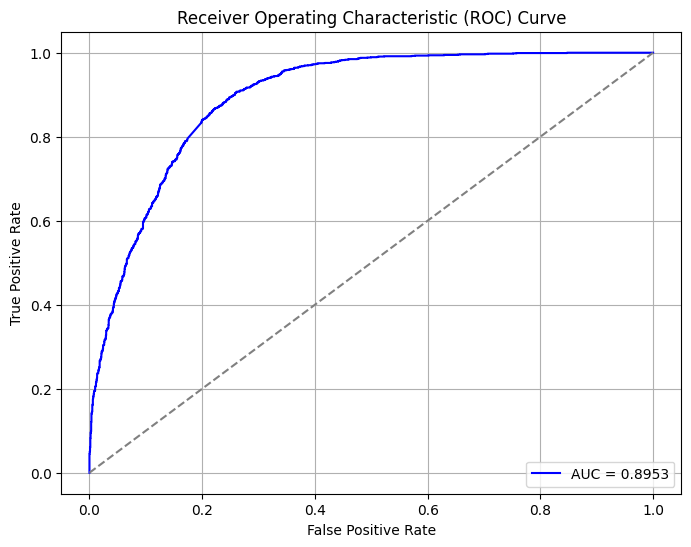

ROC Curve saved to: Window-3 seconds, Overlap-50.0%\CNN Models\Conv1D\Best_Model_Test_Results\roc_curve.png


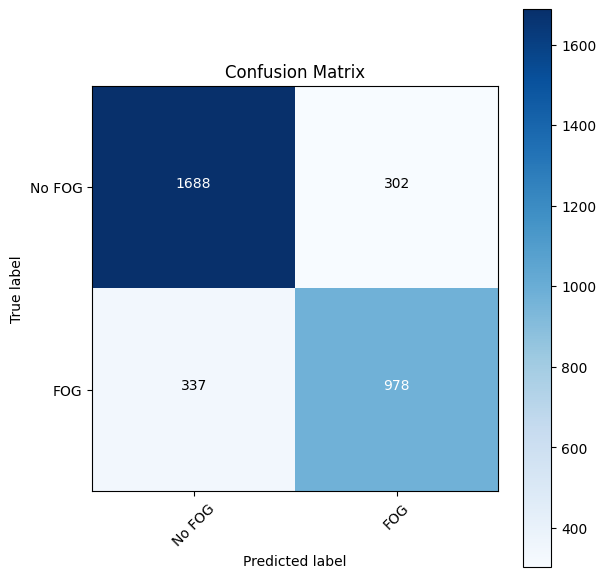

Confusion Matrix saved to: Window-3 seconds, Overlap-50.0%\CNN Models\Conv1D\Best_Model_Test_Results\confusion_matrix.png


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 298, 32)        │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 149, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 147, 40)        │         3,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 147, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 73, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 73, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │       140,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 439,997 (1.68 MB)

 Trainable params: 146,617 (572.72 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 293,236 (1.12 MB)

C:\Users\etaiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


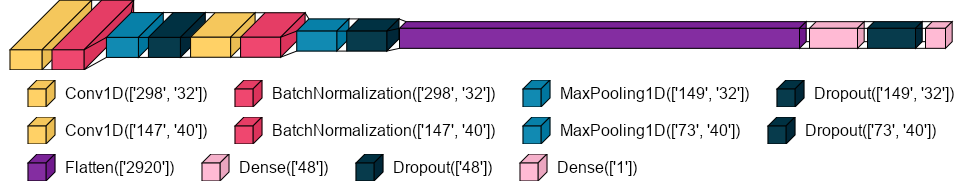

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from PIL import ImageFont
import visualkeras

# Directory to save the test results
test_results_dir = os.path.join(conv1d_output_dir, "Best_Model_Test_Results")
os.makedirs(test_results_dir, exist_ok=True)

# Path to the directory where the best model is saved
best_model_path = os.path.join(conv1d_tuning_output_dir, "best_conv1d_model.keras")
# best_model_path = os.path.join(conv1d_tuning_output_dir, "best_conv1d_model_random_search.keras")

# Load the best model
best_model = load_model(best_model_path)

# Predict on the test set
y_test_pred_prob = best_model.predict(X_test_conv1d)  # Get probabilities
y_test_pred = (y_test_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_test_conv1d, y_test_pred)
sensitivity = recall_score(y_test_conv1d, y_test_pred)  # Sensitivity = Recall
auc = roc_auc_score(y_test_conv1d, y_test_pred_prob)

# Confusion Matrix for Specificity Calculation
tn, fp, fn, tp = confusion_matrix(y_test_conv1d, y_test_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Save metrics to a CSV file
test_metrics = {
    "Metric": ["Accuracy", "Sensitivity", "Specificity", "AUC"],
    "Value": [accuracy, sensitivity, specificity, auc]
}
metrics_df = pd.DataFrame(test_metrics)
metrics_csv_path = os.path.join(test_results_dir, "test_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)

print(f"Test Metrics saved to: {metrics_csv_path}")

# Plot and save the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_conv1d, y_test_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
roc_curve_path = os.path.join(test_results_dir, "roc_curve.png")
plt.savefig(roc_curve_path)
plt.show()

print(f"ROC Curve saved to: {roc_curve_path}")

# Plot and save the Confusion Matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(6, 6))
plot_confusion_matrix(conf_matrix, classes=["No FOG", "FOG"], title="Confusion Matrix")
conf_matrix_path = os.path.join(test_results_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.show()

print(f"Confusion Matrix saved to: {conf_matrix_path}")

best_model.summary()

# Create model architecture image
font = ImageFont.truetype("arial.ttf", 16)
visualkeras.layered_view(best_model,
                        legend=True,
                        draw_volume=True,
                        scale_xy=0.5,
                        scale_z=1,
                        show_dimension=True,
                        font=font,
                        to_file='model_visualization.png')

### Run Best Conv1D Model Again

Epoch 1/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7150 - auc: 0.7811 - loss: 0.5691 - sensitivity: 0.6859 - val_accuracy: 0.7462 - val_auc: 0.8306 - val_loss: 0.5178 - val_sensitivity: 0.7601
Epoch 2/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7768 - auc: 0.8601 - loss: 0.4636 - sensitivity: 0.6987 - val_accuracy: 0.7418 - val_auc: 0.8300 - val_loss: 0.5123 - val_sensitivity: 0.7397
Epoch 3/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7960 - auc: 0.8756 - loss: 0.4390 - sensitivity: 0.7379 - val_accuracy: 0.7444 - val_auc: 0.8346 - val_loss: 0.5041 - val_sensitivity: 0.7099
Epoch 4/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8065 - auc: 0.8876 - loss: 0.4172 - sensitivity: 0.7435 - val_accuracy: 0.7611 - val_auc: 0.8518 - val_loss: 0.5121 - val_sensitivity: 0.7752
Epoch 5/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8045 - auc: 0.8872 - loss: 0.4187 - sensitivity: 0.7497 - val_accuracy: 0.7677 - val_auc: 0.8575 - val

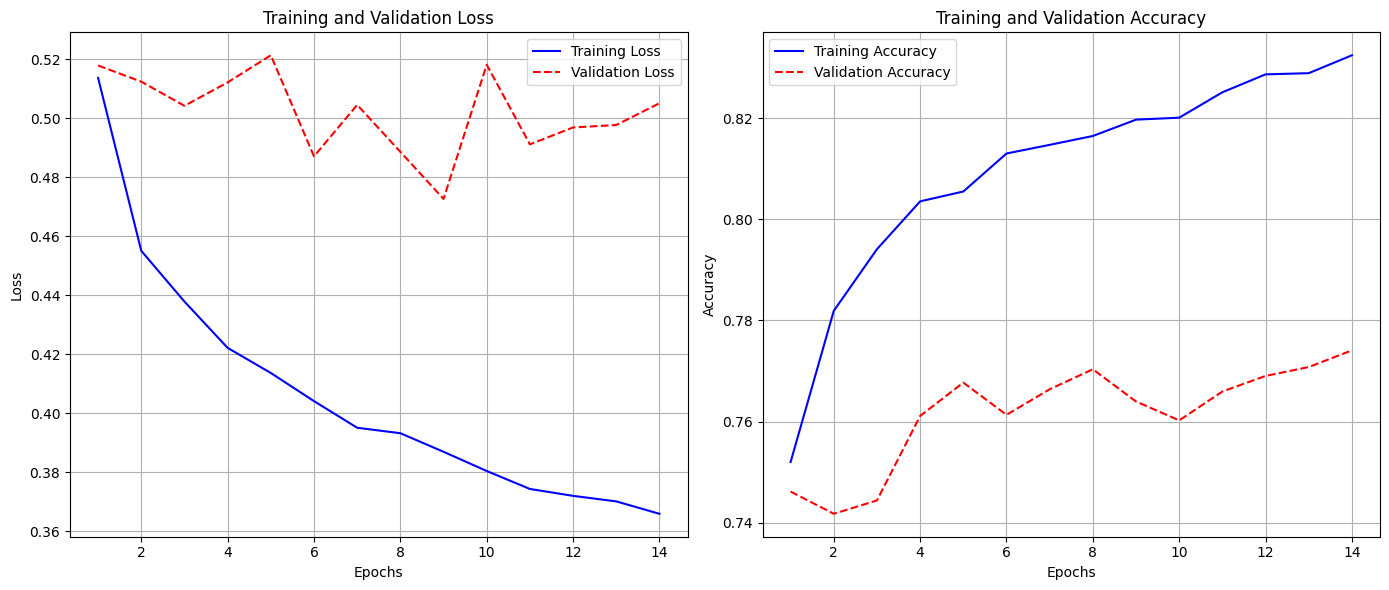

Training and validation metrics saved as subplots to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv1D\Best_Model_Test_Results\training_validation_graph.png


In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best hyperparameters from tuning
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the best model using these hyperparameters
best_model = build_conv1d_model(best_hps)

# Train the model and capture the history
history = best_model.fit(
    X_train_conv1d, y_train_conv1d,
    validation_data=(X_val_conv1d, y_val_conv1d),
    epochs=20,  # Use the same max_epochs from tuning
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)

# Save training history manually
history_path = os.path.join(conv1d_tuning_output_dir, "training_history.npy")
np.save(history_path, history)

# Load saved history
history = np.load(history_path, allow_pickle=True).item()

plot_training_curves_with_subplots(history, test_results_dir)

## Conv2D

### Initial Model

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


# Determine input shape dynamically
frequencies = X_train_conv2d.shape[1]
time_bins = X_train_conv2d.shape[2]
axes = X_train_conv2d.shape[3]

# Conv2D Model
conv2d_model = Sequential([
    Input(shape=(frequencies, time_bins, axes)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=1, activation='sigmoid')    # Binary classification
])

# Compile the model
conv2d_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_conv2d = conv2d_model.fit(X_train_conv2d, y_train_conv2d,
                                  validation_data=(X_val_conv2d, y_val_conv2d),
                                  epochs=20,
                                  batch_size=32,
                                  verbose=2)

# Save the model
conv2d_initial_output_dir = os.path.join(conv2d_output_dir, "Initial")
os.makedirs(conv2d_initial_output_dir, exist_ok=True)
conv2d_model.save(os.path.join(conv2d_initial_output_dir, "conv2d_initial_model.keras"))

Epoch 1/20
803/803 - 10s - 12ms/step - accuracy: 0.7698 - loss: 0.4835 - val_accuracy: 0.7651 - val_loss: 0.4799
Epoch 2/20
803/803 - 8s - 10ms/step - accuracy: 0.7956 - loss: 0.4318 - val_accuracy: 0.7629 - val_loss: 0.4971
Epoch 3/20
803/803 - 8s - 10ms/step - accuracy: 0.8045 - loss: 0.4127 - val_accuracy: 0.7611 - val_loss: 0.4832
Epoch 4/20
803/803 - 8s - 10ms/step - accuracy: 0.8123 - loss: 0.3945 - val_accuracy: 0.7626 - val_loss: 0.5165
Epoch 5/20
803/803 - 8s - 10ms/step - accuracy: 0.8230 - loss: 0.3742 - val_accuracy: 0.7629 - val_loss: 0.5271
Epoch 6/20
803/803 - 8s - 10ms/step - accuracy: 0.8336 - loss: 0.3527 - val_accuracy: 0.7664 - val_loss: 0.5514
Epoch 7/20
803/803 - 8s - 10ms/step - accuracy: 0.8493 - loss: 0.3224 - val_accuracy: 0.7622 - val_loss: 0.6052
Epoch 8/20
803/803 - 8s - 10ms/step - accuracy: 0.8645 - loss: 0.2903 - val_accuracy: 0.7609 - val_loss: 0.6044
Epoch 9/20
803/803 - 8s - 10ms/step - accuracy: 0.8856 - loss: 0.2561 - val_accuracy: 0.7479 - val_loss

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7608
Sensitivity: 0.6167
Specificity: 0.8550
AUC: 0.8475

Metrics Table:
        Metric     Value
0     Accuracy  0.760813
1  Sensitivity  0.616742
2  Specificity  0.854977
3          AUC  0.847549

Metrics saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\Initial\metrics_results.csv


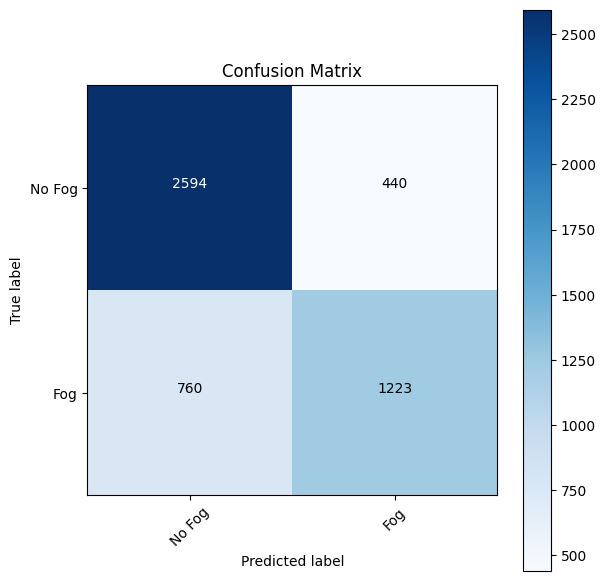

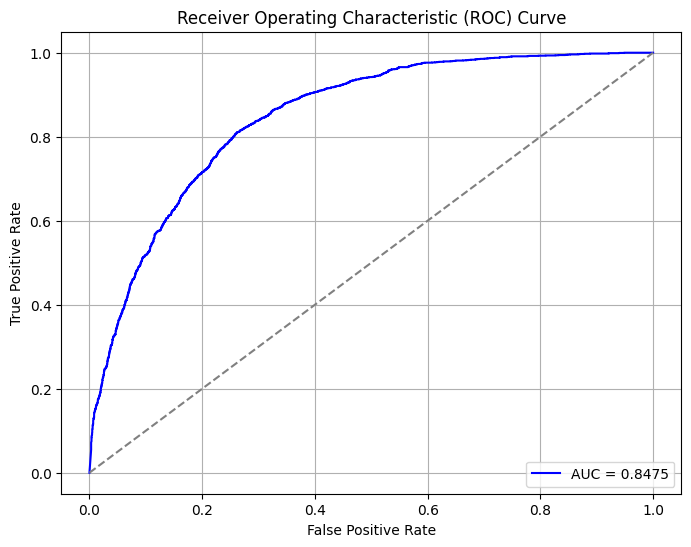

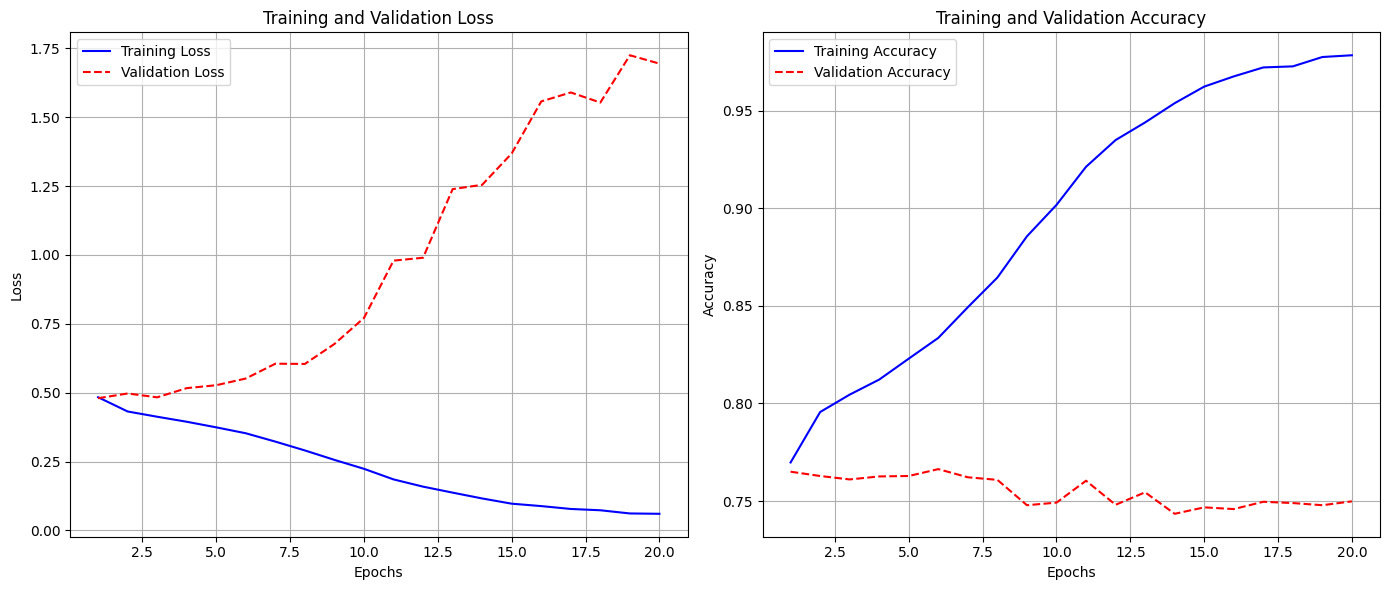

Training and validation metrics saved as subplots to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\Initial\training_validation_graph.png


In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

# Predict on the test set
y_test_pred = (conv2d_model.predict(X_test_conv2d) > 0.5).astype("int32")  # Threshold at 0.5
y_test_prob = conv2d_model.predict(X_test_conv2d).flatten()  # Probabilities for AUC

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test_conv2d, y_test_pred).ravel()

# Metrics Calculation
accuracy = accuracy_score(y_test_conv2d, y_test_pred)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity = Recall
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
auc_score = roc_auc_score(y_test_conv2d, y_test_prob)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {auc_score:.4f}")

# Create a DataFrame to store the results
import pandas as pd

metrics = {
    "Metric": ["Accuracy", "Sensitivity", "Specificity", "AUC"],
    "Value": [accuracy, sensitivity, specificity, auc_score]
}

metrics_df = pd.DataFrame(metrics)

# Save the metrics table to the specified directory
metrics_output_file = os.path.join(conv2d_initial_output_dir, "metrics_results.csv")
metrics_df.to_csv(metrics_output_file, index=False)

print("\nMetrics Table:")
print(metrics_df)
print(f"\nMetrics saved to: {metrics_output_file}")

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf_matrix = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(6, 6))
plot_confusion_matrix(conf_matrix, classes=["No Fog", "Fog"], title="Confusion Matrix")
plt.savefig(os.path.join(conv2d_initial_output_dir, "confusion_matrix.png"))
plt.show()

# Plot ROC and AUC curve
fpr, tpr, thresholds = roc_curve(y_test_conv2d, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig(os.path.join(conv2d_initial_output_dir, "auc_curve.png"))
plt.show()

def plot_training_curves_with_subplots(history, output_dir):
    # Extract loss and accuracy from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Create a figure with subplots
    plt.figure(figsize=(14, 6))

    # Subplot for Loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Subplot for Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Adjust layout and save
    plt.tight_layout()
    combined_plot_path = os.path.join(output_dir, "training_validation_graph.png")
    plt.savefig(combined_plot_path)
    plt.show()

    print(f"Training and validation metrics saved as subplots to: {combined_plot_path}")

plot_training_curves_with_subplots(history_conv2d, conv2d_initial_output_dir)

### Hyper-Parameters Tuning

#### Parameter Tuning

In [48]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Define the model-building function for Conv2D
def build_conv2d_model(hp):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=(X_train_conv2d.shape[1], X_train_conv2d.shape[2], X_train_conv2d.shape[3])))

    # Convolutional Layers
    for i in range(hp.Int("num_conv_layers", 2, 5)):  # 1 to 3 Conv2D layers
        
        kernel_size = hp.Choice(f"kernel_size_{i}", ["3x3", "5x5"])
        kernel_size_tuple = (3, 3) if kernel_size == "3x3" else (5, 5)
        
        model.add(
            Conv2D(
                filters=hp.Int(f"filters_{i}", min_value=8, max_value=128, step=8),  # Filters: 8 to 64
                kernel_size=kernel_size_tuple,  # Kernel sizes: (3, 3) or (5, 5)
                activation="relu",
                padding="same"
            )
        )
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling2D(pool_size=(1, 2)))  # Fixed max pooling
        model.add(Dropout(rate=0.4))  # Dropout: Fixed 0.4

    # Flatten and Dense Layers
    model.add(Flatten())
    for i in range(hp.Int("num_dense_layers", 1, 3)):  # 1 to 3 Dense layers
        model.add(
            Dense(
                units=hp.Int(f"dense_units_{i}", min_value=8, max_value=128, step=8),  # Dense units: 16 to 128
                activation="relu"
            )
        )
        model.add(Dropout(rate=0.4))  # Dropout for dense layers

    # Output Layer
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", 1e-5, 1e-3, sampling="log")),  # Learning rate
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Recall(name="sensitivity"), tf.keras.metrics.AUC(name="auc")],
    )
    return model

'''
# Instantiate the Random Search tuner
tuner = kt.RandomSearch(
    build_conv2d_model,
    objective=kt.Objective("val_auc", direction="max"),  # Maximize AUC
    max_trials=100,  # Number of configurations to try
    executions_per_trial=1,  # Number of training runs per configuration
    directory=os.path.join(conv2d_output_dir, "tuning"),
    project_name="conv2d_random_search"
)
'''

# Hyperband Tuner for Conv2D
tuner = kt.Hyperband(
    build_conv2d_model,  # Model-building function
    objective=kt.Objective("val_auc", direction="max"),  # Maximize AUC
    max_epochs=20,  # Maximum number of epochs per configuration
    factor=4,  # Resource reduction factor
    directory=os.path.join(conv2d_output_dir, "tuning"),
    project_name="conv2d_hyperband"
)

'''
tuner = kt.BayesianOptimization(
    build_conv2d_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=50,
    directory=os.path.join(conv2d_output_dir, "tuning"),
    project_name="conv2d_bayesian_optimization"
)
'''

# Define a callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Perform the search
tuner.search(
    X_train_conv2d, y_train_conv2d,
    validation_data=(X_val_conv2d, y_val_conv2d),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Save the best model
conv2d_tuning_output_dir = os.path.join(conv2d_output_dir, "Tuning")
os.makedirs(conv2d_tuning_output_dir, exist_ok=True)
best_model.save(os.path.join(conv2d_tuning_output_dir, "best_conv2d_model.keras"))


Trial 44 Complete [00h 14m 07s]
val_auc: 0.835289716720581

Best val_auc So Far: 0.8715963363647461
Total elapsed time: 03h 12m 09s

Best Hyperparameters:
num_conv_layers: 4
kernel_size_0: 3x3
filters_0: 64
kernel_size_1: 5x5
filters_1: 96
num_dense_layers: 2
dense_units_0: 80
learning_rate: 0.0005421195615159703
kernel_size_2: 5x5
filters_2: 48
kernel_size_3: 3x3
filters_3: 112
kernel_size_4: 3x3
filters_4: 56
dense_units_1: 16
dense_units_2: 40
tuner/epochs: 20
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0022


#### Best Trials

In [49]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix

# Directory to save the top models
top_models_dir = os.path.join(conv2d_output_dir, "top_10_models")
os.makedirs(top_models_dir, exist_ok=True)

# Get the top 10 trials from the tuner
best_trials = tuner.oracle.get_best_trials(num_trials=10)
best_models = tuner.get_best_models(num_models=10)  # Retrieve trained models

data = []
for i, (trial, model) in enumerate(zip(best_trials, best_models)):
    # Extract hyperparameters
    num_conv_layers = trial.hyperparameters.get("num_conv_layers")
    num_dense_layers = trial.hyperparameters.get("num_dense_layers")
    filters = [trial.hyperparameters.get(f"filters_{j}") for j in range(num_conv_layers)]
    kernel_sizes = [trial.hyperparameters.get(f"kernel_size_{j}") for j in range(num_conv_layers)]
    dense_units = [trial.hyperparameters.get(f"dense_units_{j}") for j in range(num_dense_layers)]
    learning_rate = trial.hyperparameters.get("learning_rate")

    # Retrieve validation metrics directly from the tuner
    val_accuracy = round(trial.metrics.get_best_value("val_accuracy"), 4)
    val_sensitivity = round(trial.metrics.get_best_value("val_sensitivity"), 4)
    val_auc = round(trial.metrics.get_best_value("val_auc"), 4)

    # Save the best model
    model_path = os.path.join(top_models_dir, f"model_{i + 1}.keras")
    model.save(model_path)

    # Calculate specificity on the validation set
    y_val_pred = (model.predict(X_val_conv2d) > 0.5).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_val_conv2d, y_val_pred).ravel()
    val_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Save model data
    trial_data = {
        "Model Rank": i + 1,
        "Num Conv Layers": num_conv_layers,
        "Filters Per Layer": filters,
        "Kernel Sizes": kernel_sizes,
        "Num Dense Layers": num_dense_layers,
        "Dense Units": dense_units,
        "Learning Rate": learning_rate,
        "Validation Accuracy": val_accuracy,
        "Validation Sensitivity": val_sensitivity,
        "Validation Specificity": round(val_specificity, 4),
        "Validation AUC": val_auc,
        "Model Path": model_path,
    }
    data.append(trial_data)

# Convert the results to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_path = os.path.join(top_models_dir, "top_10_models.csv")
df.to_csv(csv_path, index=False)

# Print the saved paths
print(f"Top models saved to: {top_models_dir}")
print(f"Metrics CSV saved to: {csv_path}")

# Display the DataFrame
print("\nTop 10 Models:")
print(df)


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Top models saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\top_10_models
Metrics CSV saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\top_10_models\top_10_models.csv

Top 10 Models:
   Model Rank  Num Conv Layers      Filters Per Layer  \
0           1                4      [64, 96, 48, 112]   
1           2                5  [64, 112, 120, 32, 8]   
2           3                2              [128, 56]   
3           4                2              [128, 56]   
4           5                4      [64, 96, 48, 112]   
5           6                5  [64

### Best Conv2D Model

C:\Users\etaiw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
Test Metrics saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\Best_Model_Test_Results\test_metrics.csv


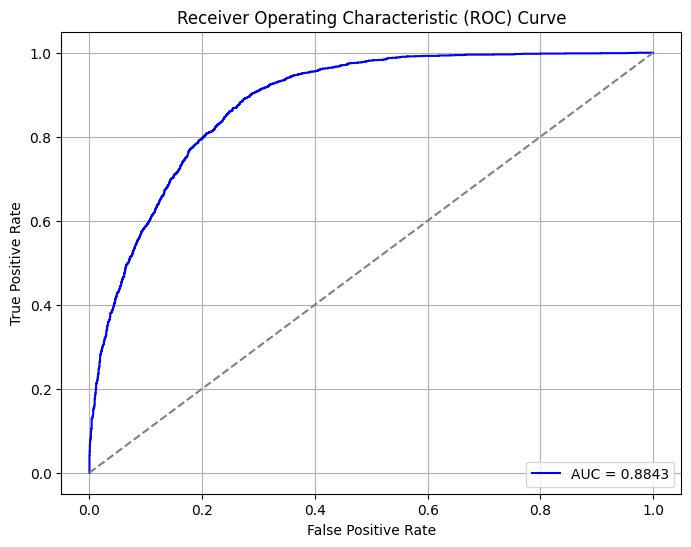

ROC Curve saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\Best_Model_Test_Results\roc_curve.png


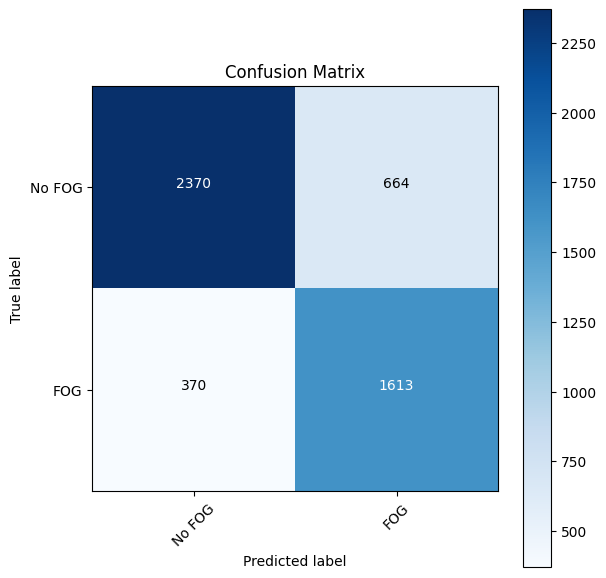

Confusion Matrix saved to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\Best_Model_Test_Results\confusion_matrix.png


In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from PIL import ImageFont
import visualkeras

# Directory to save the test results
test_results_dir = os.path.join(conv2d_output_dir, "Best_Model_Test_Results")
os.makedirs(test_results_dir, exist_ok=True)

# Path to the directory where the best model is saved
best_model_path = os.path.join(conv2d_tuning_output_dir, "best_conv2d_model.keras")
# best_model_path = os.path.join(conv2d_tuning_output_dir, "best_conv2d_model_random_search.keras")

# Load the best model
best_model = load_model(best_model_path)

# Predict on the test set
y_test_pred_prob = best_model.predict(X_test_conv2d)  # Get probabilities
y_test_pred = (y_test_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_test_conv2d, y_test_pred)
sensitivity = recall_score(y_test_conv2d, y_test_pred)  # Sensitivity = Recall
auc = roc_auc_score(y_test_conv2d, y_test_pred_prob)

# Confusion Matrix for Specificity Calculation
tn, fp, fn, tp = confusion_matrix(y_test_conv2d, y_test_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Save metrics to a CSV file
test_metrics = {
    "Metric": ["Accuracy", "Sensitivity", "Specificity", "AUC"],
    "Value": [accuracy, sensitivity, specificity, auc]
}
metrics_df = pd.DataFrame(test_metrics)
metrics_csv_path = os.path.join(test_results_dir, "test_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)

print(f"Test Metrics saved to: {metrics_csv_path}")

# Plot and save the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_conv2d, y_test_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
roc_curve_path = os.path.join(test_results_dir, "roc_curve.png")
plt.savefig(roc_curve_path)
plt.show()

print(f"ROC Curve saved to: {roc_curve_path}")

# Plot and save the Confusion Matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(6, 6))
plot_confusion_matrix(conf_matrix, classes=["No FOG", "FOG"], title="Confusion Matrix")
conf_matrix_path = os.path.join(test_results_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.show()

print(f"Confusion Matrix saved to: {conf_matrix_path}")

best_model.summary()

# Create model architecture image
font = ImageFont.truetype("arial.ttf", 16)
visualkeras.layered_view(best_model,
                        legend=True,
                        draw_volume=True,
                        scale_xy=0.5,
                        scale_z=1,
                        show_dimension=False,
                        font=font,
                        to_file='model_visualization.png')

### Run Best Conv2D Model Again

Epoch 1/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - accuracy: 0.6209 - auc: 0.6662 - loss: 0.6941 - sensitivity: 0.5893 - val_accuracy: 0.7374 - val_auc: 0.8110 - val_loss: 0.5172 - val_sensitivity: 0.7292
Epoch 2/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 98s 122ms/step - accuracy: 0.7444 - auc: 0.8197 - loss: 0.5232 - sensitivity: 0.7468 - val_accuracy: 0.7538 - val_auc: 0.8318 - val_loss: 0.5048 - val_sensitivity: 0.7904
Epoch 3/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 98s 122ms/step - accuracy: 0.7778 - auc: 0.8543 - loss: 0.4761 - sensitivity: 0.7782 - val_accuracy: 0.7571 - val_auc: 0.8470 - val_loss: 0.4880 - val_sensitivity: 0.8568
Epoch 4/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 98s 122ms/step - accuracy: 0.7857 - auc: 0.8649 - loss: 0.4629 - sensitivity: 0.8159 - val_accuracy: 0.7440 - val_auc: 0.8291 - val_loss: 0.5580 - val_sensitivity: 0.8050
Epoch 5/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 98s 122ms/step - accuracy: 0.7898 - auc: 0.8728 - loss: 0.4472 - sensitivity: 0.8096 - val_accuracy: 0.7343 - val_a

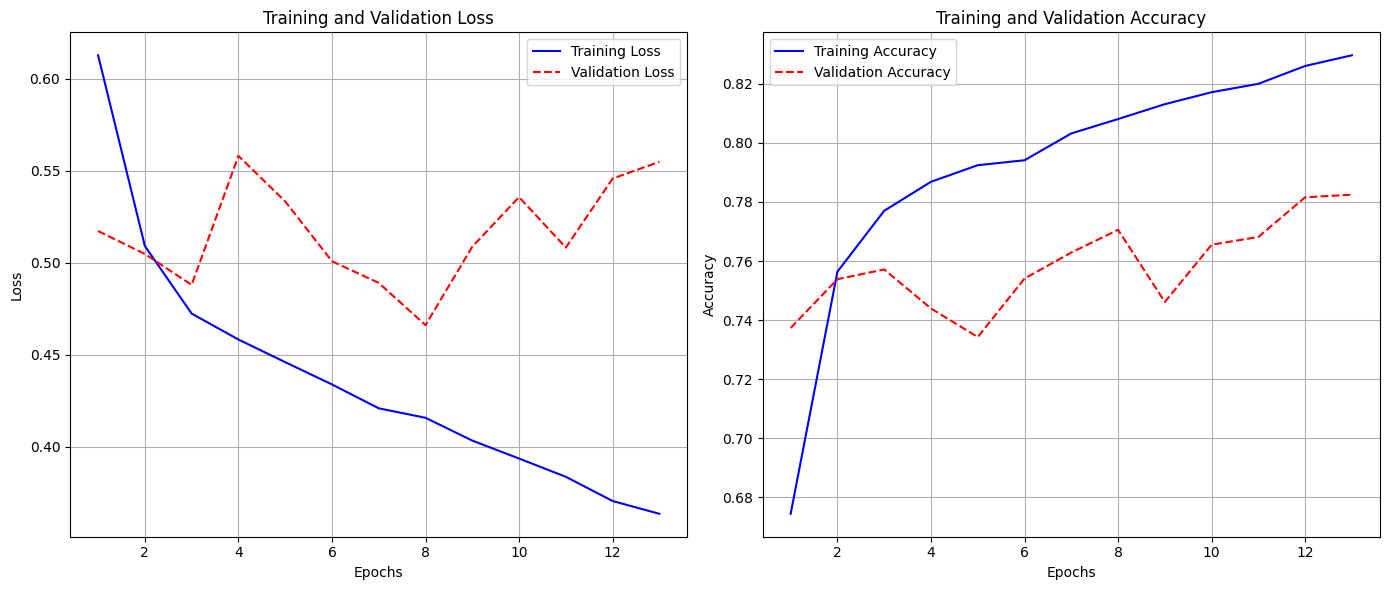

Training and validation metrics saved as subplots to: Window-2 seconds, Overlap-50.0%\CNN Models\Conv2D\Best_Model_Test_Results\training_validation_graph.png


In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best hyperparameters from tuning
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the best model using these hyperparameters
best_model = build_conv2d_model(best_hps)

# Train the model and capture the history
history = best_model.fit(
    X_train_conv2d, y_train_conv2d,
    validation_data=(X_val_conv2d, y_val_conv2d),
    epochs=20,  # Use the same max_epochs from tuning
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1
)

# Save training history manually
history_path = os.path.join(conv2d_tuning_output_dir, "training_history.npy")
np.save(history_path, history)

# Load saved history
history = np.load(history_path, allow_pickle=True).item()

plot_training_curves_with_subplots(history, test_results_dir)